In [1]:
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers.advanced_activations import SReLU, ELU
from keras.optimizers import SGD, RMSprop, Adagrad
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator

from PIL import Image
import skimage
from skimage.io import imread

import numpy as np
from scipy import signal
from scipy import misc
from scipy import ndimage

import matplotlib as mpl
import matplotlib.pyplot as plt

import os
import sys
import subprocess

import uuid
import json
import random
import math 
import csv

from time import gmtime, strftime
import datetime

NR_EPOCH = 8

BASE_MODEL_TRAINABLE    = False
BLOCK_5_TRAINABLE       = False
LAST_LAYER_TRAINABLE    = False
SOFTMAX_LAYER_TRAINABLE = False

IMGSIZE_X = 224 # IMGSIZE_X = 224
IMGSIZE_Y = 224 # IMGSIZE_Y = 224

WEIGHTS_PATH = '/Users/lucaslingle/Desktop/DeepLearning/ConvNets/Faces/src/ConvNets/vgg16_weights.h5'
DATA_DIR = '/Users/lucaslingle/git/skip-thoughts/data/'
MODELS_DIR = '/Users/lucaslingle/git/skip-thoughts/models/lucas-designed-models/'

Using Theano backend.


In [2]:
import skipthoughts
model = skipthoughts.load_model()

Loading model parameters...
Compiling encoders...
Loading tables...
Packing up...


In [3]:
def VGG_16(weights_path=None):
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(3,224,224)))
    model.add(Convolution2D(64, 3, 3, activation='relu', trainable=BASE_MODEL_TRAINABLE))
    model.add(ZeroPadding2D((1,1), trainable=BASE_MODEL_TRAINABLE))
    model.add(Convolution2D(64, 3, 3, activation='relu', trainable=BASE_MODEL_TRAINABLE))
    model.add(MaxPooling2D((2,2), strides=(2,2), trainable=BASE_MODEL_TRAINABLE))

    model.add(ZeroPadding2D((1,1), trainable=BASE_MODEL_TRAINABLE))
    model.add(Convolution2D(128, 3, 3, activation='relu', trainable=BASE_MODEL_TRAINABLE))
    model.add(ZeroPadding2D((1,1), trainable=BASE_MODEL_TRAINABLE))
    model.add(Convolution2D(128, 3, 3, activation='relu', trainable=BASE_MODEL_TRAINABLE))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1), trainable=BASE_MODEL_TRAINABLE))
    model.add(Convolution2D(256, 3, 3, activation='relu', trainable=BASE_MODEL_TRAINABLE))
    model.add(ZeroPadding2D((1,1), trainable=BASE_MODEL_TRAINABLE))
    model.add(Convolution2D(256, 3, 3, activation='relu', trainable=BASE_MODEL_TRAINABLE))
    model.add(ZeroPadding2D((1,1), trainable=BASE_MODEL_TRAINABLE))
    model.add(Convolution2D(256, 3, 3, activation='relu', trainable=BASE_MODEL_TRAINABLE))
    model.add(MaxPooling2D((2,2), strides=(2,2), trainable=BASE_MODEL_TRAINABLE))

    model.add(ZeroPadding2D((1,1), trainable=BASE_MODEL_TRAINABLE))
    model.add(Convolution2D(512, 3, 3, activation='relu', trainable=BASE_MODEL_TRAINABLE))
    model.add(ZeroPadding2D((1,1), trainable=BASE_MODEL_TRAINABLE))
    model.add(Convolution2D(512, 3, 3, activation='relu', trainable=BASE_MODEL_TRAINABLE))
    model.add(ZeroPadding2D((1,1), trainable=BASE_MODEL_TRAINABLE))
    model.add(Convolution2D(512, 3, 3, activation='relu', trainable=BASE_MODEL_TRAINABLE))
    model.add(MaxPooling2D((2,2), strides=(2,2), trainable=BASE_MODEL_TRAINABLE))

    model.add(ZeroPadding2D((1,1), trainable=(BASE_MODEL_TRAINABLE or BLOCK_5_TRAINABLE)))
    model.add(Convolution2D(512, 3, 3, activation='relu', trainable=(BASE_MODEL_TRAINABLE or BLOCK_5_TRAINABLE)))
    model.add(ZeroPadding2D((1,1), trainable=(BASE_MODEL_TRAINABLE or BLOCK_5_TRAINABLE)))
    model.add(Convolution2D(512, 3, 3, activation='relu', trainable=(BASE_MODEL_TRAINABLE or BLOCK_5_TRAINABLE)))
    model.add(ZeroPadding2D((1,1), trainable=(BASE_MODEL_TRAINABLE or BLOCK_5_TRAINABLE)))
    model.add(Convolution2D(512, 3, 3, activation='relu', trainable=(BASE_MODEL_TRAINABLE or BLOCK_5_TRAINABLE)))
    model.add(MaxPooling2D((2,2), strides=(2,2), trainable=(BASE_MODEL_TRAINABLE or BLOCK_5_TRAINABLE)))

    model.add(Flatten())
    model.add(Dense(4096, activation='relu', trainable=BASE_MODEL_TRAINABLE))
    model.add(Dropout(0.5, trainable=BASE_MODEL_TRAINABLE))
    model.add(Dense(4096, activation='relu', trainable=LAST_LAYER_TRAINABLE))
    model.add(Dropout(0.5, trainable=BASE_MODEL_TRAINABLE))
    model.add(Dense(1000, activation='softmax', trainable=SOFTMAX_LAYER_TRAINABLE))

    if weights_path:
        model.load_weights(weights_path)

    return model

In [4]:
def pop_layer(model):
    if not model.outputs:
        raise Exception('Sequential model cannot be popped: model is empty.')

    model.layers.pop()
    if not model.layers:
        model.outputs = []
        model.inbound_nodes = []
        model.outbound_nodes = []
    else:
        model.layers[-1].outbound_nodes = []
        model.outputs = [model.layers[-1].output]
    model.built = False

In [5]:
def resize_to_target_w_aspect_ratio(old_im, target_image_size):

  # stackoverflow.com/questions/11142851/adding-borders-to-an-image-using-python
  # stackoverflow.com/questions/24745857/python-pillow-how-to-scale-an-image
  # stackoverflow.com/questions/273946/how-do-i-resize-an-image-using-pil-and-maintain-its-aspect-ratio

  old_size = old_im.size
  new_im = Image.new("RGB", target_image_size, color=(255,255,255))

  if (old_size[0] < IMGSIZE_X) and (old_size[1] < IMGSIZE_Y):
    new_im.paste(old_im, ((target_image_size[0]-old_size[0])/2, (target_image_size[1]-old_size[1])/2))
  else:
    c = min(float(target_image_size[0])/float(old_size[0]), float(target_image_size[1]) / float(old_size[1]))

    resized_float_size = (c * old_size[0], c * old_size[1])
    resized_size = (int(math.floor(resized_float_size[0])), int(math.floor(resized_float_size[1])))

    # print "Original size: " + str(old_im.size)

    # This method resizes  the current image object (acts by reference, not value! Write it out first, if you want an as-is copy!)
    # That said, it does not mess up the original *file*, just the Image object in this program.
    # And of course, if you write to the same filepath as the original, that'd mess up the actual file.

    old_im.thumbnail(resized_size, Image.ANTIALIAS)

    # print "Resized size: " + str(old_im.size)

    new_im.paste(old_im, ((target_image_size[0]-resized_size[0])/2, (target_image_size[1]-resized_size[1])/2))

    # print "New size: " + str(new_im.size)

  return new_im

In [6]:
def read_image(fp):

    try:
      old_im = Image.open(fp)

      target_image_size = (IMGSIZE_X, IMGSIZE_Y)

      new_im = resize_to_target_w_aspect_ratio(old_im, target_image_size)

      formatted_fp = os.path.join("/tmp/", str(uuid.uuid4()) + ".jpg")

      new_im.save(formatted_fp)

      fmt_im = skimage.io.imread(formatted_fp, as_grey = False)

      im = fmt_im.astype(np.float32)[:,:,0:3]

      im[:,:,0] -= 103.939
      im[:,:,1] -= 116.779
      im[:,:,2] -= 123.68

      # As per remarks here
      #   https://gist.github.com/baraldilorenzo/07d7802847aaad0a35d3
      #
      # The VGG16 Model was trained on RGB colors. 
      # The openCV package used by the gist author uses BGR colors, that's why he had the "transpose 201" below.
      im = im.transpose((2,0,1))

      subprocess.check_call(["rm", formatted_fp])

      return im
    except:
      return None

In [7]:
def eval_single_image(model, dir, filename):

    fp = os.path.join(dir, filename)

    im = read_image(fp)
    im = np.expand_dims(im, axis=0)

    out = model.predict(im)

    return out

In [8]:
# Get pretrained VGG16 model
convnet = VGG_16(WEIGHTS_PATH)
opt = RMSprop()

# Chop off the sigmoid classification layer, and its dropout.
# Note that this gives CNN codes that are 1 material layer back from softmax.
# (This differs from your image regression project, where you popped 4 layers.)
pop_layer(convnet)
pop_layer(convnet)

convnet.compile(optimizer=opt, loss='mse', metrics=['accuracy'])
convnet.summary()


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 226, 226)   0           zeropadding2d_input_1[0][0]      
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 224, 224)  1792        zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 64, 226, 226)  0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 64, 224, 224)  36928       zeropadding2d_2[0][0]            
___________________________________________________________________________________________

In [9]:
cnncode = eval_single_image(
    model=convnet, \
    dir=os.path.join(DATA_DIR, 'train2014/'), \
    filename="COCO_train2014_000000575005.jpg"
)

visionVec = np.array(
    map(lambda x: float("{0:.3f}".format(math.fabs(x))), cnncode.tolist()[0]),
    dtype=np.float32)

In [10]:
# I could just use json.loads.
# Not sure if jq and subprocess is faster. I will test this.
ann_fp = os.path.join(DATA_DIR, 'annotations/captions_train2014.json')
command_str = """jq '.annotations[] | select(.image_id == 575005) | .caption' """ + ann_fp

In [11]:
jqproc = subprocess.Popen(command_str, stdout=subprocess.PIPE, stderr=subprocess.PIPE, shell=True)

raw_annotations_str = jqproc.stdout.read()
jqproc.stdout.close()

annotations = map(lambda x: x.strip("\""), raw_annotations_str.strip("\n").split("\n"))

annotations

['A big black dog sits on a bench.',
 'a black dog sitting on top of a bench on a deck ',
 'A dog sits on a bench and looks near a rock.',
 'A dog, sitting on a bench and looking out at a field.',
 'a dog sitting on a bench with a field background']

In [12]:
thoughtVecs = skipthoughts.encode(model, annotations, verbose=False)

print "VisionVec:"
print visionVec
print "ThoughtVecs"
print thoughtVecs

VisionVec:
[ 0.          0.76800001  0.226      ...,  0.134       0.          0.        ]
ThoughtVecs
[[ 0.03089085 -0.00291646  0.00085856 ...,  0.04035544  0.00221435
   0.00510866]
 [ 0.00700377  0.00281317 -0.0023839  ..., -0.00090943 -0.00421759
   0.018409  ]
 [ 0.01431105 -0.00064932 -0.00479105 ...,  0.01551358  0.00222164
   0.00468565]
 [-0.0065335  -0.00272198 -0.00567212 ..., -0.03972717  0.00386152
   0.00798063]
 [ 0.00755459 -0.00116981 -0.00111263 ..., -0.0327839   0.01011139
   0.0194642 ]]


In [13]:
old_im = Image.open(os.path.join(DATA_DIR, 'train2014/', 'COCO_train2014_000000575005.jpg'))

A big black dog sits on a bench.
a black dog sitting on top of a bench on a deck 
A dog sits on a bench and looks near a rock.
A dog, sitting on a bench and looking out at a field.
a dog sitting on a bench with a field background


[ 0.03089085 -0.00291646  0.00085856 ...,  0.04035544  0.00221435
  0.00510866]
[ 0.00700377  0.00281317 -0.0023839  ..., -0.00090943 -0.00421759  0.018409  ]
[ 0.01431105 -0.00064932 -0.00479105 ...,  0.01551358  0.00222164
  0.00468565]
[-0.0065335  -0.00272198 -0.00567212 ..., -0.03972717  0.00386152
  0.00798063]
[ 0.00755459 -0.00116981 -0.00111263 ..., -0.0327839   0.01011139
  0.0194642 ]


[ 0.          0.76800001  0.226      ...,  0.134       0.          0.        ]


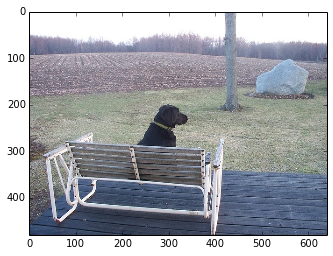

In [14]:
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image

%matplotlib inline
imshow(np.asarray(old_im))

for i in range(0,len(annotations)):
    print annotations[i]
    
print "\n"

for i in range(0,len(annotations)):
    print thoughtVecs[i]
    
print "\n"
print visionVec

In [15]:
train_dir = os.path.join(DATA_DIR, 'train2014/')
val_dir = os.path.join(DATA_DIR, 'val2014/')
test_dir = os.path.join(DATA_DIR, 'test2014/')

train_raw_output = subprocess.check_output(["ls", train_dir])
val_raw_output = subprocess.check_output(["ls", val_dir])
test_raw_output = subprocess.check_output(["ls", test_dir])

train_image_filenames = train_raw_output.strip("\n").split("\n")
val_image_filenames = val_raw_output.strip("\n").split("\n")
test_image_filenames = test_raw_output.strip("\n").split("\n")

import pandas as pd
train_img_fs_df = pd.DataFrame(train_image_filenames, columns = ["file_name"])
val_img_fs_df = pd.DataFrame(val_image_filenames, columns = ["file_name"])
test_img_fs_df = pd.DataFrame(test_image_filenames, columns = ["file_name"])

train_img_fs_df["file_path"] = train_img_fs_df["file_name"].apply(lambda x: os.path.join(train_dir, x))
val_img_fs_df["file_path"] = val_img_fs_df["file_name"].apply(lambda x: os.path.join(val_dir, x))
test_img_fs_df["file_path"] = test_img_fs_df["file_name"].apply(lambda x: os.path.join(test_dir, x))

In [16]:
train_img_fs_df.head

<bound method DataFrame.head of                              file_name  \
0      COCO_train2014_000000000009.jpg   
1      COCO_train2014_000000000025.jpg   
2      COCO_train2014_000000000030.jpg   
3      COCO_train2014_000000000034.jpg   
4      COCO_train2014_000000000036.jpg   
5      COCO_train2014_000000000049.jpg   
6      COCO_train2014_000000000061.jpg   
7      COCO_train2014_000000000064.jpg   
8      COCO_train2014_000000000071.jpg   
9      COCO_train2014_000000000072.jpg   
10     COCO_train2014_000000000077.jpg   
11     COCO_train2014_000000000078.jpg   
12     COCO_train2014_000000000081.jpg   
13     COCO_train2014_000000000086.jpg   
14     COCO_train2014_000000000089.jpg   
15     COCO_train2014_000000000092.jpg   
16     COCO_train2014_000000000094.jpg   
17     COCO_train2014_000000000109.jpg   
18     COCO_train2014_000000000110.jpg   
19     COCO_train2014_000000000113.jpg   
20     COCO_train2014_000000000127.jpg   
21     COCO_train2014_000000000138.jpg   
22

In [17]:
import json

with open(os.path.join(DATA_DIR, 'annotations/', 'captions_train2014.json')) as ann:
  training_meta_json = json.load(ann)

train_img_json = training_meta_json["images"]
train_ann_json = training_meta_json["annotations"]

In [18]:
from pandas.io.json import json_normalize

train_img_json_df = json_normalize(train_img_json)
train_ann_json_df = json_normalize(train_ann_json)

train_img_json_df = train_img_json_df.drop('coco_url', 1)
train_img_json_df = train_img_json_df.drop('date_captured', 1)
train_img_json_df = train_img_json_df.drop('flickr_url', 1)
train_img_json_df = train_img_json_df.drop('height', 1)
train_img_json_df = train_img_json_df.drop('license', 1)
train_img_json_df = train_img_json_df.drop('width', 1)

train_img_json_df["image_id"] = train_img_json_df["id"]
train_img_json_df = train_img_json_df.drop("id", 1)

train_ann_json_df["caption_id"] = train_ann_json_df["id"]
train_ann_json_df = train_ann_json_df.drop("id", 1)

train_img_json_df.reset_index(["image_id"], drop = True)
train_ann_json_df.reset_index(["image_id"], drop = True)

,caption,image_id,caption_id
0,A very clean and well decorated empty bathroom,318556,48
1,A panoramic view of a kitchen and all of its a...,116100,67
2,A blue and white bathroom with butterfly theme...,318556,126
3,A panoramic photo of a kitchen and dining room,116100,148
4,A graffiti-ed stop sign across the street from...,379340,173
5,A vandalized stop sign and a red beetle on the...,379340,188
6,A bathroom with a border of butterflies and bl...,318556,219
7,An angled view of a beautifully decorated bath...,318556,255
8,The two people are walking down the beach.,134754,272
9,A sink and a toilet inside a small bathroom.,538480,288


In [19]:
train_img_json_df

,file_name,image_id
0,COCO_train2014_000000057870.jpg,57870
1,COCO_train2014_000000384029.jpg,384029
2,COCO_train2014_000000222016.jpg,222016
3,COCO_train2014_000000520950.jpg,520950
4,COCO_train2014_000000069675.jpg,69675
5,COCO_train2014_000000547471.jpg,547471
6,COCO_train2014_000000122688.jpg,122688
7,COCO_train2014_000000392136.jpg,392136
8,COCO_train2014_000000398494.jpg,398494
9,COCO_train2014_000000090570.jpg,90570


In [20]:
import pandas as pd
train_joined_df = pd.merge(train_img_json_df, train_ann_json_df, on=['image_id'])

In [21]:
train_joined_df.shape

(414113, 4)

In [22]:
print "Sanity Checks:"

nr_img_files_in_joined_df = train_joined_df["file_name"].nunique()
nr_img_files_in_img_json_df = train_img_json_df["file_name"].nunique()
nr_img_files_in_img_fs_df = train_img_fs_df["file_name"].nunique()

nr_rows_in_img_json_df = train_img_json_df.shape[0]
nr_rows_in_img_fs_df = train_img_fs_df.shape[0]

values_to_match = []
values_to_match += [nr_img_files_in_joined_df]
values_to_match += [nr_img_files_in_img_json_df]
values_to_match += [nr_img_files_in_img_fs_df]
values_to_match += [nr_rows_in_img_json_df]
values_to_match += [nr_rows_in_img_fs_df]

if (len(set(values_to_match)) == 1):
    print "[  OK   ] Training Data Sanity Check: Filesystem vs JSON Metadata"
else:
    print "[ ERROR ] Training Data Sanity Check: Filesystem vs JSON Metadata"
    print "\t  values_to_match: " + values_to_match

nr_rows_in_joined_df = train_joined_df.shape[0]
nr_rows_in_ann_json_df = train_ann_json_df.shape[0]
values_to_match2 = values_to_match + [nr_rows_in_joined_df / 5] + [nr_rows_in_ann_json_df / 5]

# Need to investigate why this check isn't passing. 
# Is there really not 5 annotations for all training images? That would be unexpected.
if (len(set(values_to_match2)) == 1):
    print "[  OK   ] Training Data Sanity Check: Five Annotations for all training images?"
else:
    print "[ ERROR ] Training Data Sanity Check: Five Annotations for all training images?"
    print "\t  values_to_match2: " + values_to_match2.__repr__()

Sanity Checks:
[  OK   ] Training Data Sanity Check: Filesystem vs JSON Metadata
[ ERROR ] Training Data Sanity Check: Five Annotations for all training images?
	  values_to_match2: [82783, 82783, 82783, 82783, 82783, 82822, 82822]


In [23]:
train_joined_df.iloc[0:10]

,file_name,image_id,caption,caption_id
0,COCO_train2014_000000057870.jpg,57870,A restaurant has modern wooden tables and chairs.,787980
1,COCO_train2014_000000057870.jpg,57870,A long restaurant table with rattan rounded ba...,789366
2,COCO_train2014_000000057870.jpg,57870,a long table with a plant on top of it surroun...,789888
3,COCO_train2014_000000057870.jpg,57870,A long table with a flower arrangement in the ...,791316
4,COCO_train2014_000000057870.jpg,57870,A table is adorned with wooden chairs with blu...,794853
5,COCO_train2014_000000384029.jpg,384029,A man preparing desserts in a kitchen covered ...,118034
6,COCO_train2014_000000384029.jpg,384029,A chef is preparing and decorating many small ...,157682
7,COCO_train2014_000000384029.jpg,384029,A baker prepares various types of baked goods.,159179
8,COCO_train2014_000000384029.jpg,384029,a close up of a person grabbing a pastry in a ...,175826
9,COCO_train2014_000000384029.jpg,384029,Close up of a hand touching various pastries.,185540


In [24]:
def get_visionvec(image_dir, filename):  
    cnncode = eval_single_image(
            model=convnet, \
            dir=train_dir, \
            filename=file_name
        )
    
    visionVec = np.array(
          cnncode.tolist()[0],
          dtype=np.float32)
    
    return visionVec

In [25]:
modified_train_joined_df = train_joined_df.groupby("image_id").filter(lambda x: len(x) == 5)

In [26]:
print train_joined_df.shape
print modified_train_joined_df.shape

if modified_train_joined_df.shape[0] % 5 != 0:
    print "[ ERROR ] Training Data Sanity Check: Filtered for 5 annotations per image, but results not divisible by 5."
else:
    print "[  OK   ] Training Data Sanity Check: Filtered for 5 annotations per image, and results divisible by 5."

(414113, 4)
(412930, 4)
[  OK   ] Training Data Sanity Check: Filtered for 5 annotations per image, and results are divisible by 5.


In [27]:
def get_time_str():
    return datetime.datetime.now().strftime("%Y-%m-%d.%H.%M.%S")

def print_time_str():
    print get_time_str()

In [28]:
train_joined_df_columns = modified_train_joined_df.columns

colNameToIdxMap = dict()
for i in range(1, len(train_joined_df_columns)+1):
    colNameToIdxMap[train_joined_df.columns[i-1]] = i

NR_TOTAL_SAMPLES =  modified_train_joined_df.shape[0]
NR_VAL_SAMPLES = 10000
NR_TRAIN_SAMPLES = NR_TOTAL_SAMPLES - NR_VAL_SAMPLES   
# In the future, the NR_TRAIN_SAMPLES variable could be 
# smaller than simply NR_TOTAL_SAMPLES - NR_VAL_SAMPLES,
# e.g., to expedite testing.

caption_trainval_data = modified_train_joined_df["caption"].iloc[0:(NR_VAL_SAMPLES+NR_TRAIN_SAMPLES)].tolist()
caption_validation_data = caption_trainval_data[0:NR_VAL_SAMPLES]
caption_training_data = caption_trainval_data[NR_VAL_SAMPLES:(NR_VAL_SAMPLES+NR_TRAIN_SAMPLES)]

THOUGHTVECS_PRECOMPUTED = False
thoughtvec_trainval_data_array = None
thoughtvec_validation_data_array = None
thoughtvec_training_data_array = None
print "THOUGHTVECS_PRECOMPUTED: " + str(THOUGHTVECS_PRECOMPUTED)

print_time_str()

if THOUGHTVECS_PRECOMPUTED:
    thoughtvec_precomputed_path = MODELS_DIR
    thoughtvec_precomputed_filename = "thoughtvecs_2016-12-23.42.17.17.npy"
    thoughtvec_precomputed_fp = os.path.join(thoughtvec_precomputed_path, thoughtvec_precomputed_filename)
    thoughtvec_trainval_data_array = np.load(thoughtvec_precomputed_fp)
else:
    thoughtvec_trainval_data_array = skipthoughts.encode(model, \
                                                         caption_trainval_data, \
                                                         verbose=False)

thoughtvec_validation_data_array = thoughtvec_trainval_data_array[0:NR_VAL_SAMPLES,]
thoughtvec_training_data_array = thoughtvec_trainval_data_array[NR_VAL_SAMPLES:(NR_VAL_SAMPLES+NR_TRAIN_SAMPLES),]
    
print_time_str()

training_data = []
validation_data = []

THOUGHTVECS_PRECOMPUTED: True
2016-12-30.17.37.10
2016-12-30.17.38.09


In [29]:
thoughtvec_zoo_fp = os.path.join(MODELS_DIR, "thoughtvecs_" + get_time_str() + ".npy")

if not THOUGHTVECS_PRECOMPUTED:
    np.save(thoughtvec_zoo_fp, thoughtvec_trainval_data_array)

In [30]:
modified_train_joined_df.iloc[0:10] # we should probably save this somewhere...

,file_name,image_id,caption,caption_id
0,COCO_train2014_000000057870.jpg,57870,A restaurant has modern wooden tables and chairs.,787980
1,COCO_train2014_000000057870.jpg,57870,A long restaurant table with rattan rounded ba...,789366
2,COCO_train2014_000000057870.jpg,57870,a long table with a plant on top of it surroun...,789888
3,COCO_train2014_000000057870.jpg,57870,A long table with a flower arrangement in the ...,791316
4,COCO_train2014_000000057870.jpg,57870,A table is adorned with wooden chairs with blu...,794853
5,COCO_train2014_000000384029.jpg,384029,A man preparing desserts in a kitchen covered ...,118034
6,COCO_train2014_000000384029.jpg,384029,A chef is preparing and decorating many small ...,157682
7,COCO_train2014_000000384029.jpg,384029,A baker prepares various types of baked goods.,159179
8,COCO_train2014_000000384029.jpg,384029,a close up of a person grabbing a pastry in a ...,175826
9,COCO_train2014_000000384029.jpg,384029,Close up of a hand touching various pastries.,185540


In [33]:
VISIONVECS_PRECOMPUTED = False
print "VISIONVECS_PRECOMPUTED: " + str(VISIONVECS_PRECOMPUTED)

from IPython.display import clear_output

visionvec_trainval_data = []

visionvec_trainval_data_array = None
visionvec_validation_data_array = None
visionvec_training_data_array = None

print_time_str()

if VISIONVECS_PRECOMPUTED:
    visionvec_precomputed_path = MODELS_DIR
    visionvec_precomputed_filename = "visionvecs_2016-12-25.12.02.02.npy"
    visionvec_precomputed_fp = os.path.join(visionvec_precomputed_path, visionvec_precomputed_filename)
    visionvec_trainval_data_array = np.load(visionvec_precomputed_fp)
else:
    
    current_image_id = -1
    current_visionVec = None
    
    for row in modified_train_joined_df.iloc[0:(NR_VAL_SAMPLES+NR_TRAIN_SAMPLES)].itertuples():
        index = row[0]
        print "processing index " + str(index)
        clear_output(wait=True)
    
        image_id = row[colNameToIdxMap["image_id"]]
        file_name = row[colNameToIdxMap["file_name"]]
    
        if image_id != current_image_id: 
            visionVec = get_visionvec(train_dir, file_name)
            current_visionVec = visionVec
            current_image_id = image_id
        
        visionvec_trainval_data.append(current_visionVec)
        
    visionvec_trainval_data_array = np.array(visionvec_trainval_data)

visionvec_validation_data_array = visionvec_trainval_data_array[0:NR_VAL_SAMPLES,]
visionvec_training_data_array = visionvec_trainval_data_array[NR_VAL_SAMPLES:(NR_VAL_SAMPLES+NR_TRAIN_SAMPLES),]
    
print_time_str()

VISIONVECS_PRECOMPUTED: True
2016-12-30.17.38.10
2016-12-30.17.39.20


In [34]:
print "\n\nShapes: \n"
print "len(caption_trainval_data):\t\t" + str(len(caption_trainval_data))
print "visionvec_trainval_data_array.shape:\t\t" + str(visionvec_trainval_data_array.shape)
print "thoughtvec_trainval_data_array.shape:\t\t" + str(thoughtvec_trainval_data_array.shape)
print "\n"
print "len(caption_training_data):\t\t" + str(len(caption_training_data))
print "visionvec_training_data_array.shape:\t\t" + str(visionvec_training_data_array.shape)
print "thoughtvec_training_data_array.shape:\t\t" + str(thoughtvec_training_data_array.shape)
print "\n"
print "len(caption_validation_data):\t\t " + str(len(caption_validation_data))
print "visionvec_validation_data_array.shape:\t\t " + str(visionvec_validation_data_array.shape)
print "thoughtvec_validation_data_array.shape:\t\t " + str(thoughtvec_validation_data_array.shape)



Shapes: 

len(caption_trainval_data):		412930
visionvec_trainval_data_array.shape:		(412930, 4096)
thoughtvec_trainval_data_array.shape:		(412930, 4800)


len(caption_training_data):		402930
visionvec_training_data_array.shape:		(402930, 4096)
thoughtvec_training_data_array.shape:		(402930, 4800)


len(caption_validation_data):		 10000
visionvec_validation_data_array.shape:		 (10000, 4096)
thoughtvec_validation_data_array.shape:		 (10000, 4800)


In [35]:
visionvec_zoo_fp = os.path.join(MODELS_DIR, "visionvecs_" + get_time_str() + ".npy")

if not VISIONVECS_PRECOMPUTED:
    np.save(visionvec_zoo_fp, visionvec_trainval_data_array)

In [37]:
training_data = [caption_training_data, \
                 visionvec_training_data_array, \
                 thoughtvec_training_data_array]

validation_data = [caption_validation_data, \
                   visionvec_validation_data_array, \
                   thoughtvec_validation_data_array]

train = training_data
dev = validation_data

In [38]:
model_filename = ""

RELOAD_MODEL = False
RELOAD_MODEL_FILENAME = "cocorank1000_combine_2016-12-28.17.36.43_reloaded.npz"

if RELOAD_MODEL:
    model_filename = RELOAD_MODEL_FILENAME
else:
    model_filename = "cocorank1000_combine_" + get_time_str() + ".npz"
    
model_zoo_fp = os.path.join(MODELS_DIR, model_filename)

In [ ]:
import eval_rank

eval_rank.trainer(train, \
                  dev, \
                  saveto=model_zoo_fp, \
                  reload_ = RELOAD_MODEL)

{'dim': 1000, 'optimizer': 'adam', 'validFreq': 500, 'reload_': True, 'dim_im': 4096, 'batch_size': 100, 'saveFreq': 500, 'saveto': '/Users/lucaslingle/git/skip-thoughts/models/lucas-designed-models/cocorank1000_combine_2016-12-28.17.36.43_reloaded.npz', 'ncon': 50, 'lrate': 0.01, 'max_epochs': 15, 'dispFreq': 10, 'margin': 0.2, 'dim_s': 4800, 'valid_batch_size': 100}
Reloading options
Building model
Reloading model
Building encoder
Building functions
Computing gradients
Optimization
Epoch  0 Update  10 Cost  276.618530273 UD  1.16832304001
Epoch  0 Update  20 Cost  334.217132568 UD  1.17495298386
Epoch  0 Update  30 Cost  337.147674561 UD  1.10903191566
Epoch  0 Update  40 Cost  340.460205078 UD  1.06964111328
Epoch  0 Update  50 Cost  366.901031494 UD  1.13762593269
Epoch  0 Update  60 Cost  325.234863281 UD  1.12491512299
Epoch  0 Update  70 Cost  331.643707275 UD  1.53722190857
Epoch  0 Update  80 Cost  335.561523438 UD  1.1471760273
Epoch  0 Update  90 Cost  186.939300537 UD  1.20

In [71]:
train_joined_df["caption"].iloc[0:10].tolist()

[u'A restaurant has modern wooden tables and chairs.',
 u'A long restaurant table with rattan rounded back chairs.',
 u'a long table with a plant on top of it surrounded with wooden chairs ',
 u'A long table with a flower arrangement in the middle for meetings',
 u'A table is adorned with wooden chairs with blue accents.',
 u'A man preparing desserts in a kitchen covered in frosting.',
 u'A chef is preparing and decorating many small pastries.',
 u'A baker prepares various types of baked goods.',
 u'a close up of a person grabbing a pastry in a container',
 u'Close up of a hand touching various pastries.']

In [72]:
model_zoo_fp = os.path.join(MODELS_DIR, 'cocorank1000_combine.npz')

In [85]:
results = eval_rank.evaluate(
    dev,
    model_zoo_fp, \
    evaluate=True, \
    out=True)

Loading model...
Building encoder
Compute embeddings...
Image to text: 21.5, 52.5, 69.5, 5.0
Text to image: 12.2, 30.3, 40.4, 21.0


In [91]:
results[0][0].shape

(1000,)

In [92]:
results[1][0].shape

(1000,)

In [96]:
diff = (results[0][0] - results[1][0])
np.sqrt(diff.dot(diff))

1.3888732

In [98]:
dev[0][0]

u'A restaurant has modern wooden tables and chairs.'

In [236]:
from scipy.linalg import norm

def get_t2i(images, captions, npts=None):
    """
    Images: (5N, K) matrix of images
    Captions: (5N, K) matrix of captions
    """
    if npts == None:
        npts = images.shape[0] / 5
    ims = np.array([images[i] for i in range(0, len(images), 5)])

    # Project images
    for i in range(len(ims)):
        ims[i] /= norm(ims[i])

    # Project captions
    for i in range(len(captions)):
        captions[i] /= norm(captions[i])

    ranks = np.zeros(5 * npts)
    for index in range(npts):

        # Get query captions
        queries = captions[5*index : 5*index + 5]

        # Compute scores
        d = np.dot(queries, ims.T)
        inds = np.zeros(d.shape)
        for i in range(len(inds)):
            inds[i] = np.argsort(d[i])[::-1]
            ranks[5 * index + i] = np.where(inds[i] == index)[0][0]

    return ranks

In [243]:
# rankings is a NR_POINTS-length array that is computed as follows:
# rankings[i] uses the i-th correct image-and-caption pair
#   and tells us that if we take the image caption and embed it, 
#   the correct image comes up in the seach results as the rankings[i] -th highest result.

rankings = get_t2i(results[0], results[1])

In [244]:
rankings[0:20]

array([  9.,   2.,   0.,   1.,   0.,  25.,   9.,  34.,   5.,  20.,   3.,
         1.,   1.,   8.,  19.,  11.,   7.,  18.,   0.,  10.])

In [238]:
print rankings[0]
print caption_training_data[0]

9.0
A restaurant has modern wooden tables and chairs.


In [150]:
train_joined_df[train_joined_df["caption"] == caption_training_data[0]]["file_name"]

0    COCO_train2014_000000057870.jpg
Name: file_name, dtype: object

In [152]:
get_visionvec(train_dir, "COCO_train2014_000000057870.jpg")

array([  1.30584037e+00,  -1.49011612e-08,   6.70254588e-01, ...,
         2.98023224e-08,  -8.94069672e-08,   3.55382562e+00], dtype=float32)

In [154]:
train_joined_df.iloc[0:10]

,file_name,image_id,caption,caption_id
0,COCO_train2014_000000057870.jpg,57870,A restaurant has modern wooden tables and chairs.,787980
1,COCO_train2014_000000057870.jpg,57870,A long restaurant table with rattan rounded ba...,789366
2,COCO_train2014_000000057870.jpg,57870,a long table with a plant on top of it surroun...,789888
3,COCO_train2014_000000057870.jpg,57870,A long table with a flower arrangement in the ...,791316
4,COCO_train2014_000000057870.jpg,57870,A table is adorned with wooden chairs with blu...,794853
5,COCO_train2014_000000384029.jpg,384029,A man preparing desserts in a kitchen covered ...,118034
6,COCO_train2014_000000384029.jpg,384029,A chef is preparing and decorating many small ...,157682
7,COCO_train2014_000000384029.jpg,384029,A baker prepares various types of baked goods.,159179
8,COCO_train2014_000000384029.jpg,384029,a close up of a person grabbing a pastry in a ...,175826
9,COCO_train2014_000000384029.jpg,384029,Close up of a hand touching various pastries.,185540


In [195]:
train_joined_df.iloc[1]

file_name                       COCO_train2014_000000057870.jpg
image_id                                                  57870
caption       A long restaurant table with rattan rounded ba...
caption_id                                               789366
Name: 1, dtype: object

In [133]:
len(np.zeros(rankings[0].shape))

5

In [130]:
cosineSim = np.dot(results[0][0], results[0][1999]) / (np.dot(results[0][0], results[0][0]) * np.dot(results[0][1999], results[0][1999]))

In [131]:
cosineSim

0.2817193

In [155]:
get_visionvec(train_dir, "COCO_train2014_000000384029.jpg")

array([  1.30584037e+00,  -1.49011612e-08,   6.70254588e-01, ...,
         2.98023224e-08,  -8.94069672e-08,   3.55382562e+00], dtype=float32)

In [160]:
import cPickle as pkl
import theano
import theano.tensor as tensor

print "Loading model..."

saveto = model_zoo_fp
with open('%s.pkl'%saveto, 'rb') as f:
    model_options = pkl.load(f)

params = eval_rank.init_params(model_options)
params = eval_rank.load_params(saveto, params)
tparams = eval_rank.init_tparams(params)

print 'Building encoder'
inps_e, lim, ls = eval_rank.build_encoder(tparams, model_options)
f_emb = theano.function(inps_e, [lim, ls], profile=False)

#print 'Compute embeddings...'
#lim, ls = f_emb(X[1], X[2])

Loading model...
Building encoder
Compute embeddings...


In [234]:
lim, ls = f_emb(visionvec_training_data_array[0:10], thoughtvec_training_data_array[0:10])

In [235]:
lim[0].dot(ls[0]) / lim[0].dot(lim[0]) * ls[0].dot(ls[0])

0.032817058

In [173]:
print lim[8].dot(ls[8])

0.0383681


In [262]:
from scipy.linalg import norm

def retrieve_images(vision_vec_data_array, captions, npts=None):
    """
    Images: (5N, K) matrix of images' visionvecs
    Captions: caption in english.
    """
    print "Loading model..."
    with open('%s.pkl'%saveto, 'rb') as f:
        model_options = pkl.load(f)

    params = eval_rank.init_params(model_options)
    params = eval_rank.load_params(saveto, params)
    tparams = eval_rank.init_tparams(params)

    print 'Building encoder'
    inps_e, lim, ls = eval_rank.build_encoder(tparams, model_options)
    f_emb = theano.function(inps_e, [lim, ls], profile=False)

    print 'Compute embeddings...'
    if type(captions) == 'str':
        captions = [captions]
    thoughtvecs = skipthoughts.encode(model, captions, verbose=False)
    image_emb_commonspace, caption_emb_commonspace = f_emb(vision_vec_data_array, thoughtvecs)

    # Project images
    for i in range(len(image_emb_commonspace)):
        image_emb_commonspace[i] /= norm(image_emb_commonspace[i])

    # Project captions
    for i in range(len(caption_emb_commonspace)):
        caption_emb_commonspace[i] /= norm(caption_emb_commonspace[i])
    
    # Compute scores
    d = np.dot(caption_emb_commonspace, image_emb_commonspace.T)
    inds = np.argsort(d)[::-1]

    return d, inds

In [263]:
caption = train_joined_df.iloc[0:10]["caption"]
d, inds = retrieve_images(visionvec_training_data_array, caption)

Loading model...
Building encoder
Compute embeddings...


In [264]:
inds

array([[6753, 6749, 6750, ..., 2969, 2970, 2971],
       [7827, 7824, 7828, ..., 8427, 8425, 8426],
       [5968, 5969, 5970, ..., 3822, 3823, 3824],
       ..., 
       [5827, 5823, 5824, ...,    4,    2,    0],
       [8589, 8588, 8586, ..., 1804, 1805, 1806],
       [8589, 8585, 8588, ...,  397,  398,  399]])

In [265]:
d

array([[ 0.03551556,  0.03551556,  0.03551556, ..., -0.04996409,
        -0.04996408, -0.04996408],
       [ 0.04134091,  0.04134091,  0.04134091, ..., -0.03807609,
        -0.0380761 , -0.0380761 ],
       [ 0.04424584,  0.04424584,  0.04424584, ..., -0.04308795,
        -0.04308795, -0.04308795],
       ..., 
       [-0.00492902, -0.00492902, -0.00492902, ...,  0.00576285,
         0.00576284,  0.00576284],
       [-0.01523871, -0.01523871, -0.01523871, ...,  0.01834627,
         0.01834626,  0.01834626],
       [-0.01046501, -0.01046501, -0.01046501, ...,  0.00153573,
         0.00153573,  0.00153573]], dtype=float32)

In [217]:
results_test

array([[8589, 8585, 8588, ...,  397,  398,  399]])

In [218]:
results_test[0][9900:]

array([ 755,  754,  752,  753,  751, 9010, 9008, 9007, 9009, 9006, 8915,
       8916, 8917, 8918, 8919, 7189, 7190, 7191, 7193, 7192, 8959, 8958,
       8957, 8960, 8956, 1843, 1844, 1845, 1846, 1842, 9626, 9627, 9628,
       9629, 9630, 4288, 4287, 4291, 4289, 4290, 1486, 1489, 1488, 1487,
       1490,   60,   61,   62,   63,   64,    3,    2,    1,    4,    0,
       3712, 3713, 3714, 3715, 3716, 5701, 5700, 5702, 5699, 5698, 4253,
       4254, 4255, 4256, 4252, 6567, 6564, 6565, 6563, 6566, 5048, 5049,
       5047, 5050, 5051, 9345, 9344, 9342, 9341, 9343,  134,  133,  132,
        131,  130, 1805, 1804, 1803, 1802, 1806,  400,  396,  397,  398,
        399])

array([-0.00098057,  0.01174505,  0.01174505,  0.01174505,  0.01174505,
        0.01174505, -0.01192261, -0.01192261, -0.01192261, -0.01192261,
       -0.01192261, -0.02005802, -0.02005802, -0.02005802, -0.02005802,
       -0.02005802,  0.00354998,  0.00354998,  0.00354998,  0.00354998,
        0.00354998,  0.01360913,  0.01360913,  0.01360913,  0.01360913,
        0.01360913, -0.01936385, -0.01936385, -0.01936385, -0.01936385,
       -0.01936385, -0.01011286, -0.01011286, -0.01011286, -0.01011286,
       -0.01011286, -0.01340753, -0.01340753, -0.01340753, -0.01340753,
       -0.01340753, -0.0097132 , -0.0097132 , -0.0097132 , -0.0097132 ,
       -0.0097132 , -0.0499641 , -0.0499641 , -0.04996411, -0.04996411], dtype=float32)